# EDA and Load Estimation of Heating and Cooling Data
Written by Marshall Mykietyshyn

Data hosted at __[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Energy+efficiency)__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from lazypredict.Supervised import LazyRegressor
from my_regression import whitening_transform, adjusted_R2


/home/marshineer/anaconda3/envs/regression/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data Exploration and Pre-processing

In [2]:
# Import the data and check for NaNs
ccpp_data = pd.read_csv('data/power_plant_data.csv')
col_names = ['Temperature', 'AmbientPressure', 'RelativeHumidity', 'ExhaustVacuum', 'EnergyOutput']
ccpp_data.columns = col_names
display(ccpp_data.head(n=10))


,Temperature,AmbientPressure,RelativeHumidity,ExhaustVacuum,EnergyOutput
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
5,13.97,39.16,1016.05,84.60,470.96
6,22.10,71.29,1008.20,75.38,442.35
7,14.47,41.76,1021.98,78.41,464.00
8,31.25,69.51,1010.25,36.83,428.77
9,6.77,38.18,1017.80,81.13,484.31


In [3]:
# Check for NaNs
ccpp_data.isna().sum()


Temperature         0
AmbientPressure     0
RelativeHumidity    0
ExhaustVacuum       0
EnergyOutput        0
dtype: int64

              Specs    Score
0       Temperature 85097.76
1   AmbientPressure 29722.29
2  RelativeHumidity  3516.04
3     ExhaustVacuum  1713.85


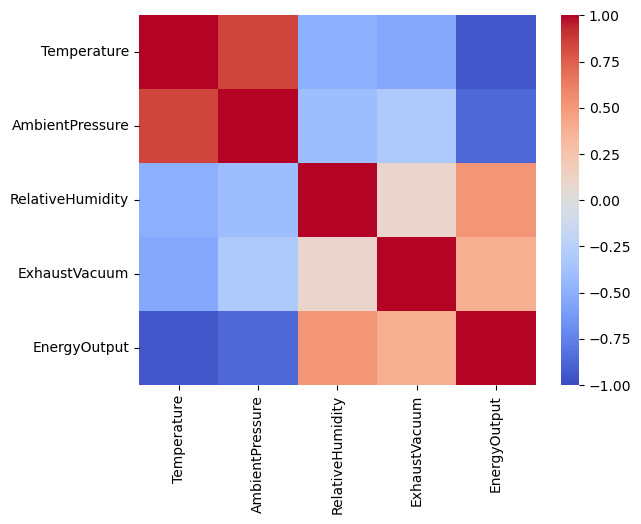

In [4]:
# Perform feature analysis in two ways
X = ccpp_data.iloc[:, :-1]
y = ccpp_data.iloc[:, -1]
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print 10 best features

# Double check with correlation heat map
sns.heatmap(ccpp_data.corr(), cmap='coolwarm', vmin=-1, vmax=1);


The strongest correlations exist between temperature and ambient pressure and the target variable, energy output. This agrees with the feature importance scores. According to these scores, the relative humidity and exhaust vacuum are much less important in predicting the target.

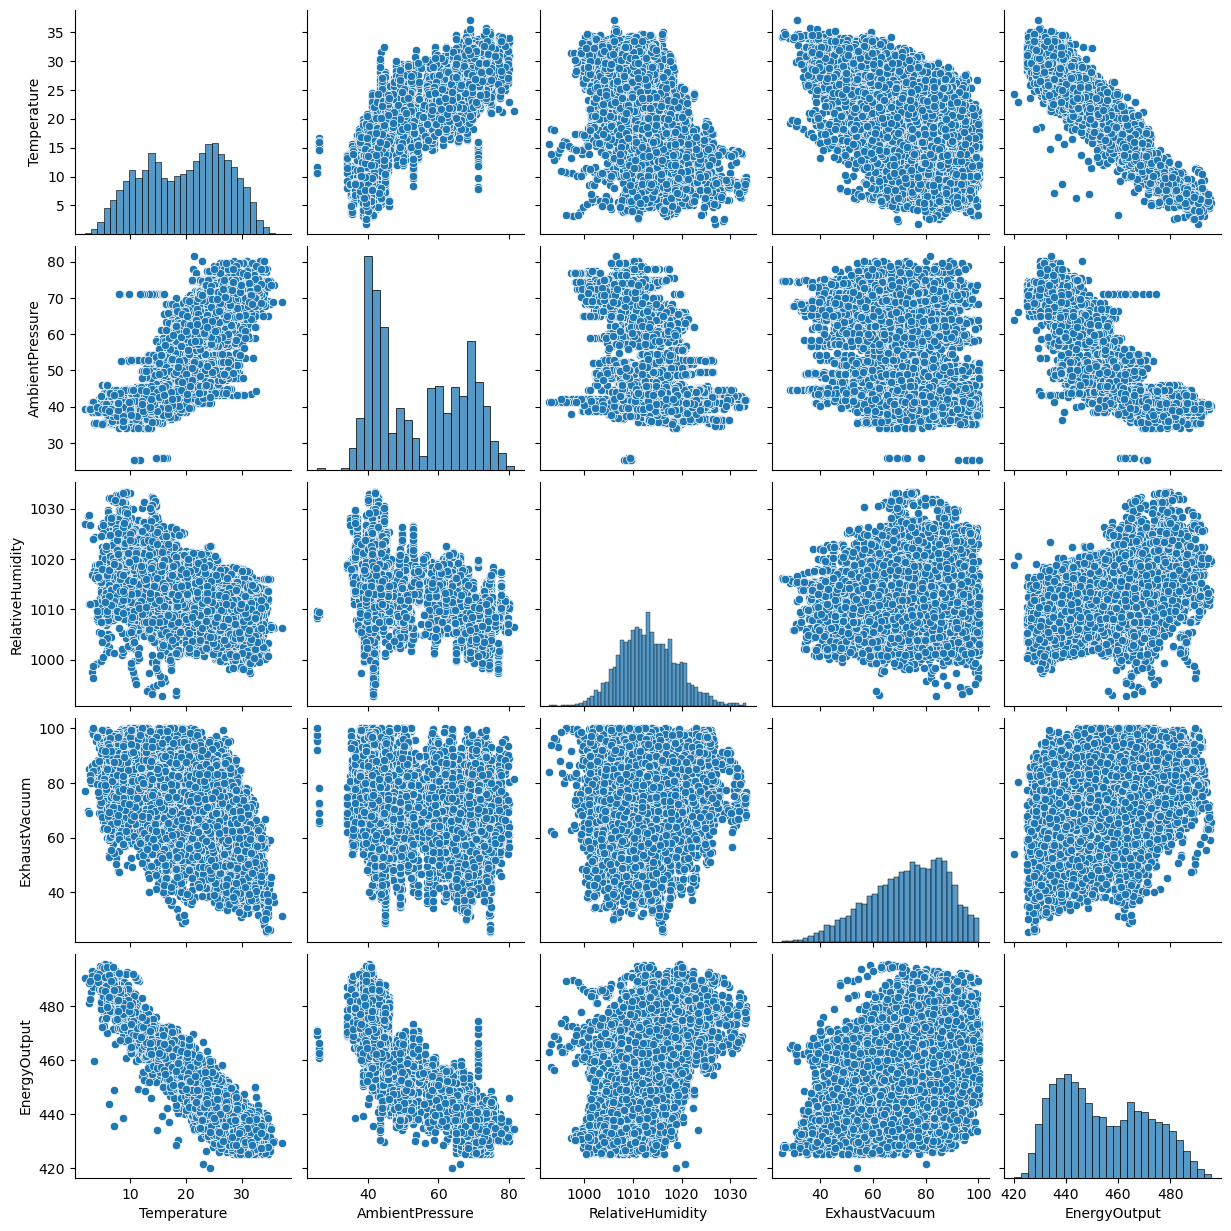

In [5]:
# Look at the distribution of variables and visualize their correlations
sns.pairplot(ccpp_data);


In [6]:
# Convert to np.array
# ccpp_data_select = ccpp_data.drop(columns=['AmbientPressure', 'RelativeHumidity'])
ccpp_data_select = ccpp_data.drop(columns=[])
ccpp_data_nd = ccpp_data_select.values


In [7]:
# Split the data into training and test sets
X_nd = ccpp_data_nd[:, :-1]
y_nd = ccpp_data_nd[:, -1]
X_train, X_extra, y_train, y_extra = train_test_split(X_nd, y_nd, test_size=0.3, random_state=66, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_extra, y_extra, test_size=0.5)
N_valid, p_valid = X_valid.shape
N_test, p_test = X_test.shape
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


(6697, 4)
(1435, 4)
(1436, 4)


(4, 4)
(4, 6697)


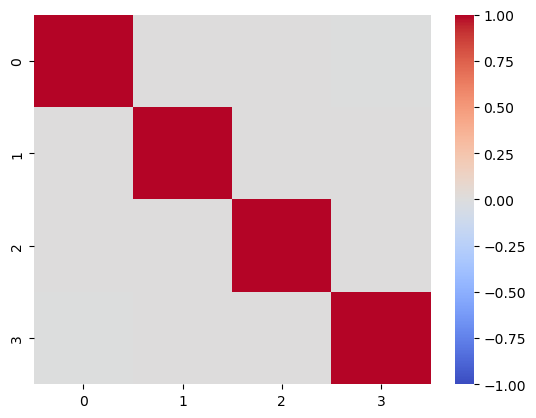

In [8]:
# Whiten the data using the training parameters
# Centering
X_train_center = X_train - X_train.mean(axis=0)
X_valid_center = X_valid - X_train.mean(axis=0)
X_test_center = X_test - X_train.mean(axis=0)

# Whitening
W = whitening_transform(X_train_center)
print(W.shape)
X_white_train = W @ X_train_center.T
X_white_valid = W @ X_valid_center.T
X_white_test = W @ X_test_center.T

# Check whitening: covariance matrix should be identity
print(X_white_train.shape)
sns.heatmap(np.cov(X_white_train), cmap='coolwarm', vmin=-1, vmax=1);


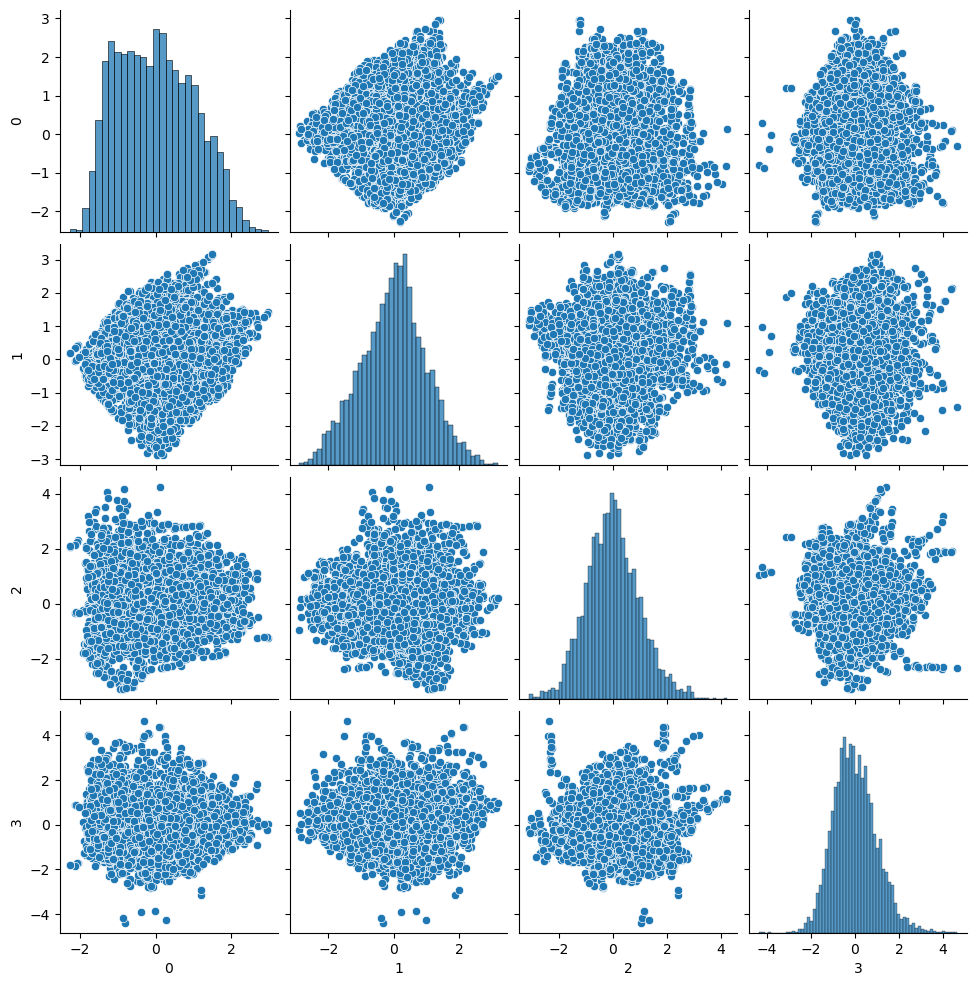

In [9]:
sns.pairplot(pd.DataFrame(X_white_train.T));


# Machine Learning

In [10]:
# Compare using lazypredict
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, pred = reg.fit(X_white_valid.T, X_white_test.T, y_valid, y_test)
models.head(n=10)


100%|████████████████████████████████████████████████████████████████████| 42/42 [00:17<00:00,  2.46it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.94,0.94,4.26,0.21
LGBMRegressor,0.93,0.93,4.40,0.05
PoissonRegressor,0.93,0.93,4.43,0.01
RandomForestRegressor,0.93,0.93,4.44,0.34
HistGradientBoostingRegressor,0.93,0.93,4.46,0.22
HuberRegressor,0.93,0.93,4.47,0.01
TransformedTargetRegressor,0.93,0.93,4.48,0.01
OrthogonalMatchingPursuitCV,0.93,0.93,4.48,0.01
LinearRegression,0.93,0.93,4.48,0.01


## Model Selection and Further Analysis
Perform k-fold cross-validation with a parameter grid search to improve model performance

In [11]:
# Define and train a baseline model
baseline_model = LGBMRegressor()
baseline_model.fit(X_train, y_train)
baseline_R2 = baseline_model.score(X_test, y_test)

# Check the effects of whitening
whitened_model = LGBMRegressor()
whitened_model.fit(X_white_train.T, y_train)
whitened_R2 = whitened_model.score(X_white_test.T, y_test)

# Set up the model evaluation
model = LGBMRegressor(max_depth=3)
score_metric = 'neg_root_mean_squared_error'
num_leaves = [2, 4, 8, 16, 32]
learning_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
n_estimators = [50, 100, 200, 400, 800]
subsample = [0.2, 0.6, 1.]

# Initialize the matrices
train_scores = np.zeros((len(num_leaves), len(learning_rate), len(n_estimators), len(subsample), 2))
valid_scores = np.zeros((len(num_leaves), len(learning_rate), len(n_estimators), len(subsample), 2))
param_mat = np.zeros((len(num_leaves), len(learning_rate), len(n_estimators), len(subsample)))

# Perform the parameter search
for i, leaves in enumerate(num_leaves):
    model.num_leaves = leaves
    for j, lr in enumerate(learning_rate):
        model.learning_rate = lr
        for k, est in enumerate(n_estimators):
            model.n_estimators = est
            for m, samp in enumerate(subsample):
                model.subsample = samp
                scores = cross_validate(model, X_train, y_train, cv=5, scoring=score_metric, return_train_score=True)
                train_scores[i, j, k, m, 0] = scores['train_score'].mean()
                train_scores[i, j, k, m, 1] = scores['train_score'].std()
                valid_scores[i, j, k, m, 0] = scores['test_score'].mean()
                valid_scores[i, j, k, m, 1] = scores['test_score'].std()


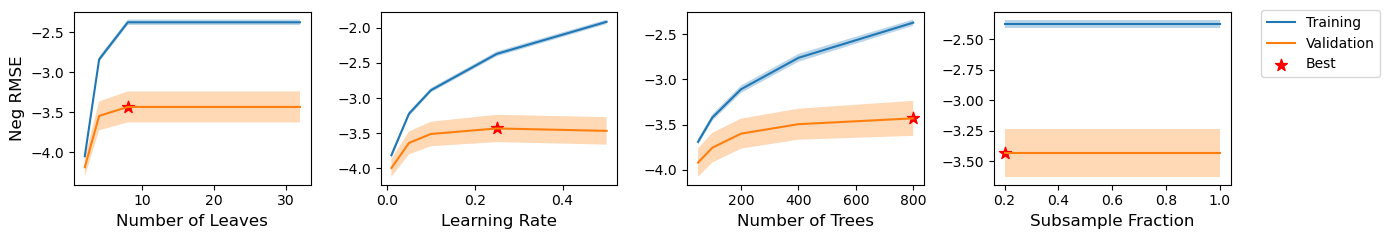

In [12]:
# Find the best parameter combination
score_dims = train_scores.shape[:-1]
best_valid_params = np.unravel_index(np.argmax(valid_scores[:, :, :, :, 0]), shape=score_dims)
param_ls = [num_leaves, learning_rate, n_estimators, subsample]

# Plot the progression along each of the best parameter directions
x_lbls = ['Number of Leaves', 'Learning Rate', 'Number of Trees', 'Subsample Fraction']
plt_lbls = ['Training', 'Validation']
train_valid_scores = np.stack((train_scores, valid_scores), axis=-1)
fig, axes = plt.subplots(1, 4, figsize=(14, 2.5))
for i, idx in enumerate(best_valid_params):
    curr_data = train_valid_scores
    ax_k = 0
    for k in range(len(best_valid_params)):
        if k == i:
            ax_k += 1
            continue
        curr_data = np.take(curr_data, best_valid_params[k], axis=ax_k)
    for j, lbl in enumerate(plt_lbls):
        axes[i].plot(param_ls[i], curr_data[:, 0, j], label=plt_lbls[j])
        axes[i].fill_between(param_ls[i], curr_data[:, 0, j] - curr_data[:, 1, j],
                             curr_data[:, 0, j] + curr_data[:, 1, j], alpha=0.3)
    axes[i].scatter(param_ls[i][idx], curr_data[idx, 0, -1], c='r', marker='*', s=80, label='Best')
    axes[i].set_xlabel(x_lbls[i], fontsize=12)
axes[0].set_ylabel('Neg RMSE', fontsize=12)
axes[-1].legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')
fig.tight_layout();


In [13]:
# Baseline and whitened model metrics
print(f'Test RMSE on baseline model: {mean_squared_error(y_test, baseline_model.predict(X_test), squared=False):4.3f}')
print(f'Test R^2 on baseline model: {baseline_R2:4.3f}')
print()
print(f'Test RMSE on whitened data: {mean_squared_error(y_test, whitened_model.predict(X_white_test.T), squared=False):4.3f}')
print(f'Test R^2 on whitened data: {whitened_R2:4.3f}')
print()

b_nl = np.max(num_leaves)
b_lr = np.max(learning_rate)
b_nt = np.max(n_estimators)
best_model = LGBMRegressor(max_depth=3, num_leaves=b_nl, learning_rate=b_lr, n_estimators=b_nt)
X_train_best, y_train_best = np.concatenate((X_train, X_valid), axis=0), np.concatenate((y_train, y_valid), axis=0)
best_model.fit(X_train_best, y_train_best, eval_metric=score_metric)
best_model.score(X_test, y_test)
y_hat_train = best_model.predict(X_train_best)
print(f'Training RMSE on best model: {mean_squared_error(y_train_best, y_hat_train, squared=False):4.3f}')
y_hat_test = best_model.predict(X_test)
print(f'Validation RMSE on best model: {mean_squared_error(y_test, y_hat_test, squared=False):4.3f}')
print(f'Validation R^2 on best model: {best_model.score(X_test, y_test):4.3f}')


Training RMSE on baseline model: 3.542
Test R^2 on baseline model: 0.957

Training RMSE on whitened data: 4.025
Test R^2 on whitened data: 0.944

Training RMSE on best model: 2.101
Test RMSE on best model: 3.310
Test R^2 on best model: 0.962


# Deep Learning

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.size

    def __getitem__(self, idx):
        features = self.data[idx, :]
        label = self.labels[idx]
        return features, label

    
# Define the model class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        bin_class = self.linear_relu_stack(x)
        return bin_class


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float()).squeeze()
        loss = loss_fn(pred, y.float())
        batch_loss.append(loss.detach().numpy())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return batch_loss


def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float()).squeeze()
            test_loss += loss_fn(pred, y.float().squeeze()).item()

    test_loss /= num_batches
    
    return pred, test_loss


In [16]:
# Define hyperparameters
learning_rate = 1e-6
batch_size = 20
epochs = 200

# Define the training and test data loaders
train_data_set = CustomDataset(X_white_train.T.astype(np.float32), y_train.astype(np.int64))
valid_data_set = CustomDataset(X_white_valid.T.astype(np.float32), y_valid.astype(np.int64))
train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data_set, batch_size=1, shuffle=True)

# Initialize a model
neural_net = NeuralNetwork(X_white_train.T.shape[-1], 128, 1).to('cpu')
neural_net = neural_net.float()

# Initialize the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate)


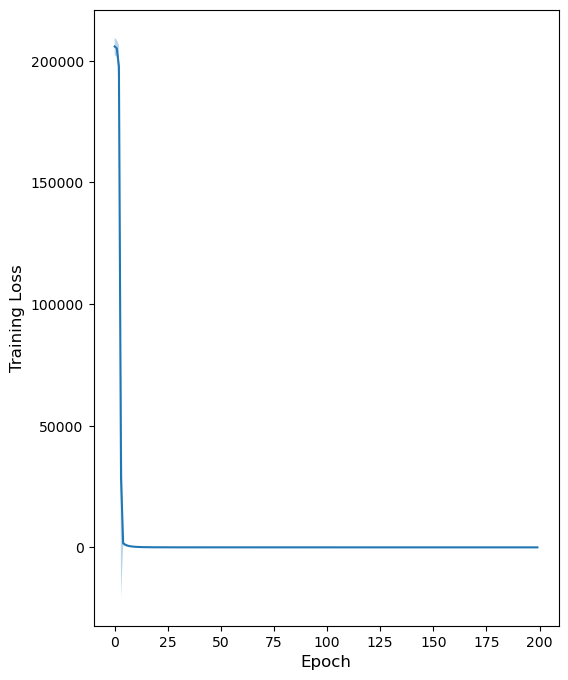

In [17]:
# Train the model
loss_avg = np.zeros(epochs)
loss_std = np.zeros(epochs)
preds = np.zeros(epochs)
valid_loss = np.zeros(epochs)
for t in range(epochs):
    epoch_loss = train_loop(train_dataloader, neural_net, loss_fn, optimizer)
    loss_avg[t] = np.mean(epoch_loss)
    loss_std[t] = np.std(epoch_loss)
    epoch_pred, epoch_loss = validation_loop(valid_dataloader, neural_net, loss_fn)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 8), sharex=True)
ax.plot(np.arange(epochs), loss_avg)
ax.fill_between(np.arange(epochs), loss_avg - loss_std, loss_avg + loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12);


In [18]:
y_train_nn = neural_net(torch.Tensor(X_white_train.T)).squeeze().detach().numpy()
y_test_nn = neural_net(torch.Tensor(X_white_test.T)).squeeze().detach().numpy()
print(f'Training RMSE on NN model: {mean_squared_error(y_train, y_train_nn, squared=False):4.3f}')
print(f'Test RMSE on NN model: {mean_squared_error(y_test, y_test_nn, squared=False):4.3f}')
print(f'Test R^2 on NN model: {r2_score(y_test, y_test_nn):4.3f}')


Training RMSE on NN model: 4.284
Test RMSE on NN model: 4.332
Test R^2 on NN model: 0.935


I am surprised the neural network does not outperform the traditional machine learning techniques. Both the training and test RMSE are relatively large, which indicates that the model is underfitting. There is likely some way the neural network model can be improved. This will be explored in future projects.